In [1]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))
from indirect_identification.armax import ARMAX
from indirect_identification.d_tfs import d_tfs
import numpy as np
from scipy import signal, optimize
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

from search.hull_helpers import expand_convex_hull, compare_hulls


# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))

Current Directory: C:\Users\Jake\Learning-Dynamic-Systems\search\notebooks
Parent Directory: C:\Users\Jake\Learning-Dynamic-Systems
Current Directory: C:\Users\Jake\Learning-Dynamic-Systems\search\notebooks
Parent Directory: C:\Users\Jake\Learning-Dynamic-Systems


## Setup

In [2]:
from search.test_systems import OpenLoop1, OpenLoop2, ClosedLoop1, ClosedLoop2, a1_true, a2_true, b1_true, b2_true
from search.search import SPSSearch
from indirect_identification.sps_indirect import SPS_indirect_model
from indirect_identification.tf_methods.fast_tfs_methods_fast_math import _is_stable
from indirect_identification.d_tfs import d_tfs
from dB.sim_db import SPSType
from scipy import optimize

from indirect_identification.sps_utils import get_construct_ss_from_params_method
n_samples = 1000

IS_VERBOSE = False

# Initialise SPS
m = 100
q = 5
n = 100

armax_model = OpenLoop1
is_closed_loop = armax_model in [ClosedLoop1, ClosedLoop2]
sps_type = SPSType.CLOSED_LOOP if is_closed_loop else SPSType.OPEN_LOOP

n_a = len(armax_model.A) - 1
n_b = len(armax_model.B)


# Initialise the system
R = signal.square(np.linspace(0, 10*np.pi, n_samples))
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)

epsilon = 1e-10

# SISO System
n_outputs = 1
n_inputs = 1
n_noise = -1
n_states=max(n_a, n_b)

C_obs = np.array([[0, 1.0]])

if n_states == 1:
    C_obs = np.array([[1.0]])


model = SPS_indirect_model(m, q, N=n,
                           n_states=n_states, n_inputs=n_inputs, n_outputs=n_outputs,
                           n_noise=n_noise)

_construct_ss_from_params = get_construct_ss_from_params_method(n_states=n_states, n_inputs=n_inputs, n_outputs=n_outputs, C=C_obs)

def get_error_norm(coord, Y, U):
    try:
        if np.any(np.isnan(coord)):
            return 1e10

        A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(coord)
        G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False, epsilon=epsilon)

        C = np.empty((n_outputs, 1))
        H = d_tfs((np.array([1.0]), A))
        # Hinv=d_tfs((A,np.array([1.0])))

        G0 = G
        H0 = H

        F = d_tfs((np.array(armax_model.F), [1.0]))
        L = d_tfs((np.array(armax_model.L), [1.0]))

        local_U = U

        if is_closed_loop:
            G0, H0 = model.transform_to_open_loop(G=G, H=H, F=F, L=L)

            local_U = R # Sneaky
            if not _is_stable(G0.den, epsilon=epsilon):
                return 1e10

        if not is_closed_loop:
            if not _is_stable(A, epsilon=epsilon):
                return 1e10

        Hinv = 1.0 / H0

        YGU = Y - G0*local_U
        N = Hinv * YGU

        error_norm = np.linalg.norm(N@N.T)
    except:
        error_norm = 1e10

    return error_norm

def get_lse(Y,U):
    x0 = np.zeros(n_a + n_b)
    res = optimize.least_squares(get_error_norm, x0, args=(Y,U))
    params_ls = res.x
    return params_ls

lse = get_lse(Y, U)
print(lse)

def is_inside_region(point):
    try :
        A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(np.ascontiguousarray(point))
        G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False, epsilon=epsilon)
        if not _is_stable(A, epsilon=epsilon):
            return False
        C = np.array([1.0])


        F = d_tfs((np.array(armax_model.F), [1.0])) if is_closed_loop else None
        L = d_tfs((np.array(armax_model.L), [1.0])) if is_closed_loop else None

        H = d_tfs((C,A))

        in_sps = model.sps_indicator(G=G, H=H, A=A, B=B, C=C,
                            Y_t = np.array([Y]), U_t=np.array([U]), sps_type=sps_type, Lambda=None, F=F, L=L, R_t=np.array([R]))
    except Exception as e:
        if IS_VERBOSE:
            print(f"Error in SPS check: {e}")
        in_sps = False
    return in_sps

[0.67904477 0.39659823]


# Baseline

In [3]:
# Grid search

n_params = len(armax_model.A) - 1 + len(armax_model.B)
mins = [0] * n_params
maxes = [1] * n_params
n_points = 20
F = armax_model.F
L = armax_model.L

search_space = []
for _ in range(n_params):
    search_space.append(np.linspace(mins[0], maxes[0], n_points))

# Create a list of arrays to pass to meshgrid
axes = [np.linspace(0, 1, n_points) for _ in range(n_params)]

# Create the meshgrid (with indexing='ij' for mathematical consistency)
mesh = np.meshgrid(*axes, indexing='ij')

# Stack and reshape to get a list of all coordinate points
points = np.stack(mesh, axis=-1).reshape(-1, n_params)
baseline_in = []
baseline_out = []
center = lse

for point in points:
    # point = np.array([a, b])
    in_sps = is_inside_region(point)
    if in_sps:
        baseline_in.append(point)
    else:
        baseline_out.append(point)

baseline_in = np.array(baseline_in)
baseline_out = np.array(baseline_out)


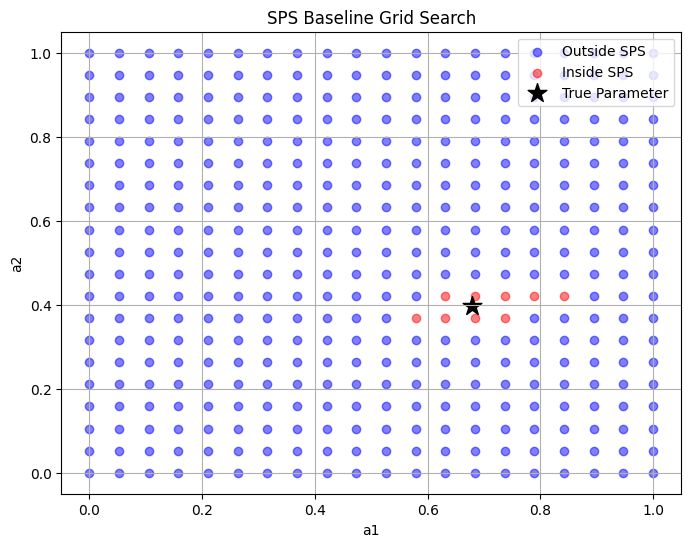

In [4]:

# Plotting
plt.figure(figsize=(8, 6))
if len(baseline_out):
    plt.scatter(baseline_out[:, 0], baseline_out[:, 1], color='blue', label='Outside SPS', alpha=0.5)
if len(baseline_in):
    plt.scatter(baseline_in[:, 0], baseline_in[:, 1], color='red', label='Inside SPS', alpha=0.5)
plt.scatter(center[0], center[1], color='black', s=200, marker='*', label='True Parameter')
plt.xlabel("a1")
plt.ylabel("a2")
plt.title("SPS Baseline Grid Search")
plt.legend()
plt.grid(True)
plt.savefig("figures/sps_baseline.png")

# Plotting
if n_params > 2:
    plt.figure(figsize=(8, 6))
    if len(baseline_out):
        plt.scatter(baseline_out[:, 2], baseline_out[:, 3], color='blue', label='Outside SPS', alpha=0.5)
    if len(baseline_in):
        plt.scatter(baseline_in[:, 2], baseline_in[:, 3], color='red', label='Inside SPS', alpha=0.5)
    plt.scatter(center[2], center[3], color='black', s=200, marker='*', label='True Parameter')
    plt.xlabel("b1")
    plt.ylabel("b2")
    plt.title("SPS Baseline Grid Search")
    plt.legend()
    plt.grid(True)
    plt.savefig("figures/sps_baseline.png")
plt.show()

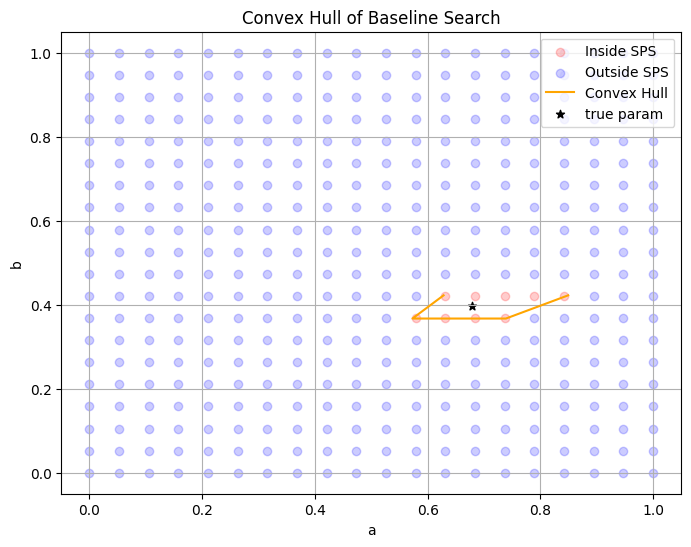

In [5]:
# Hull code
baseline_hull = ConvexHull(baseline_in)
baseline_expanded = expand_convex_hull(baseline_in[baseline_hull.vertices])

# Plot the baseline hull
plt.figure(figsize=(8, 6))
if len(baseline_in):
    plt.scatter(baseline_in[:, 0], baseline_in[:, 1], color='red', label='Inside SPS', alpha=0.2)
if len(baseline_out):
    plt.scatter(baseline_out[:, 0], baseline_out[:, 1], color='blue', label='Outside SPS', alpha=0.2)
plt.plot(baseline_expanded[:,0], baseline_expanded[:,1], color='orange', label="Convex Hull")
plt.scatter(center[0], center[1], color='black', marker='*', label='true param')
plt.xlabel("a")
plt.ylabel("b")
plt.title("Convex Hull of Baseline Search")
plt.legend()
plt.grid(True)
plt.savefig("figures/sps_baseline_hull.png")
plt.show()

# Compare two hulls
# https://github.com/mhdadk/sutherland-hodgman





# KNN Benchmark

In [6]:
# Measure of 'goodness' of confidence region approximation against a baseline
# Calculate the area of the intersection


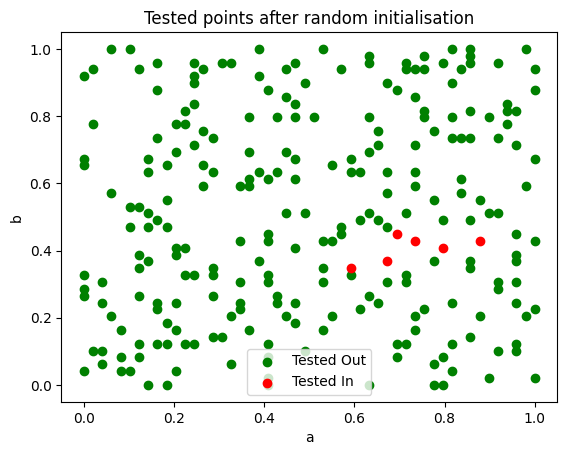

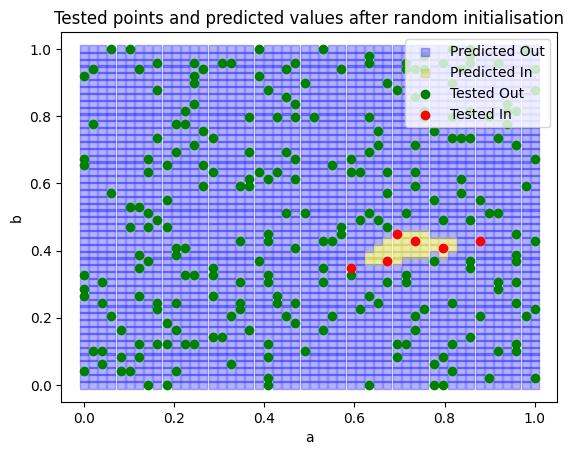

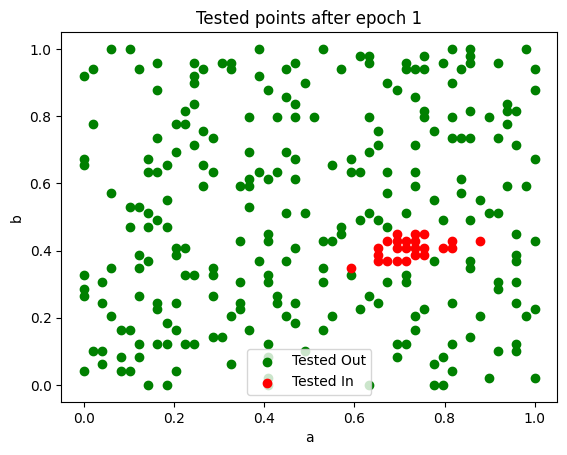

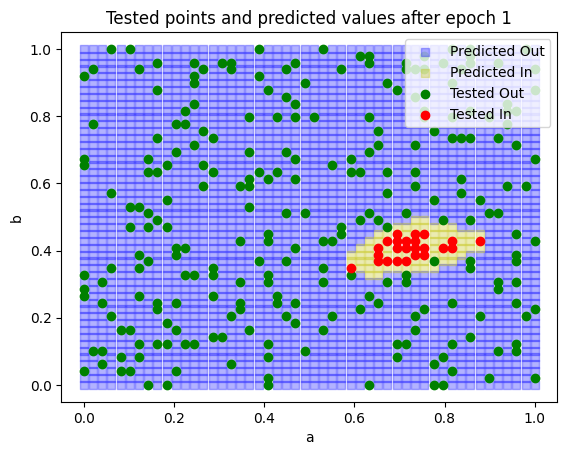

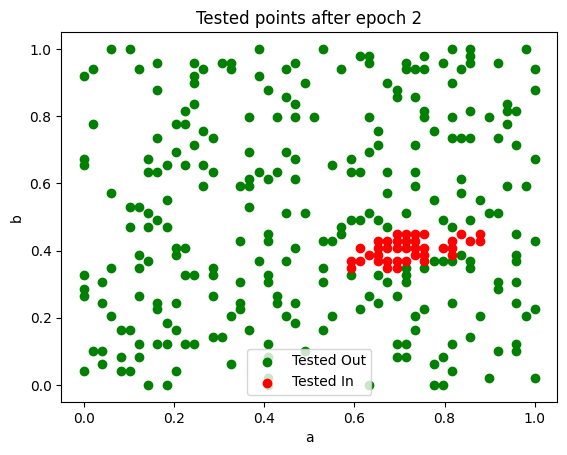

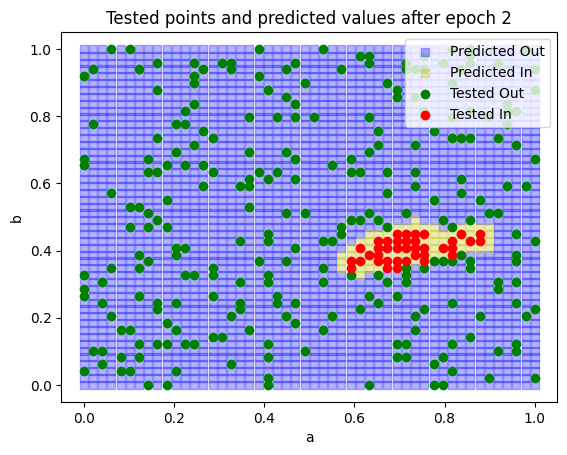

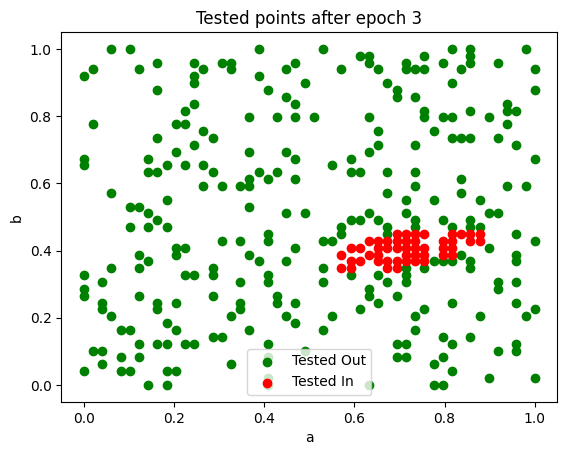

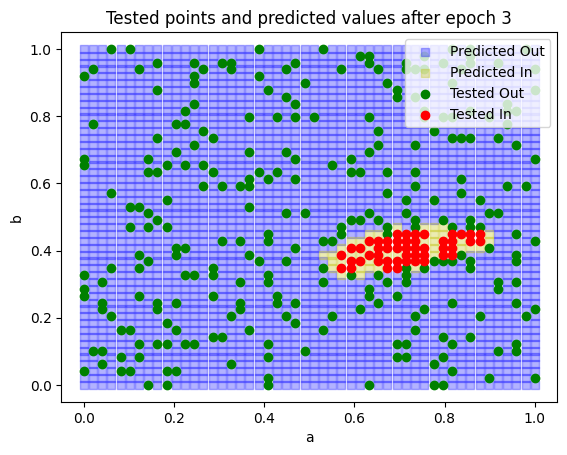

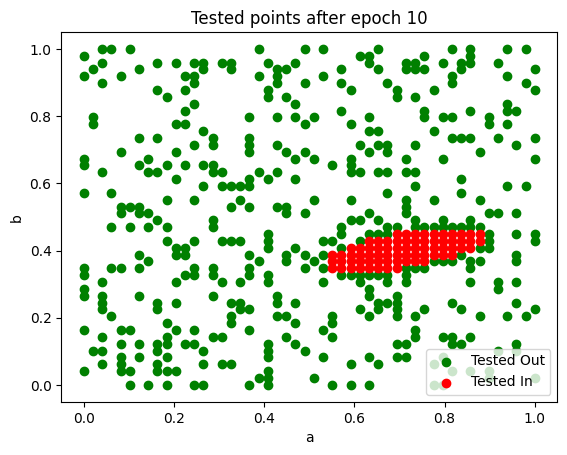

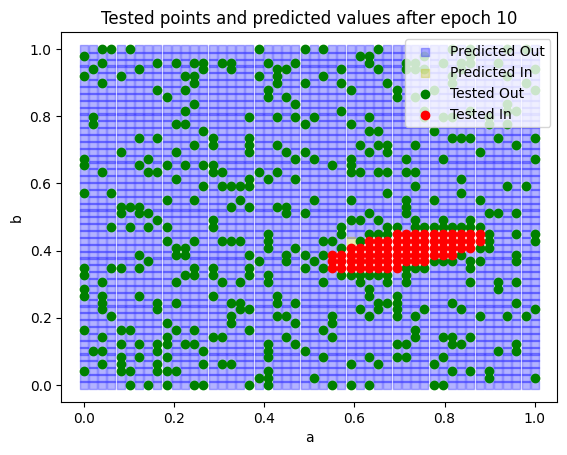

Total SPS calls:  874


In [7]:
n_sps_calls = 0

def search_test_function(coord):
    global n_sps_calls
    n_sps_calls += 1
    return is_inside_region(coord)


n_params = len(armax_model.A) - 1 + len(armax_model.B)


search = SPSSearch(
        mins=[0]*n_params,
        maxes=[1]*n_params,
        n_dimensions=n_params,
        n_points=[50]*n_params,
        search_size=0.25,
        test_cb=search_test_function,
    )
search.go()

search.plot_epoch(0)
search.plot_epoch(1)
search.plot_epoch(2)
search.plot_epoch(3)
search.plot_epoch(10)
print("Total SPS calls: ", n_sps_calls)

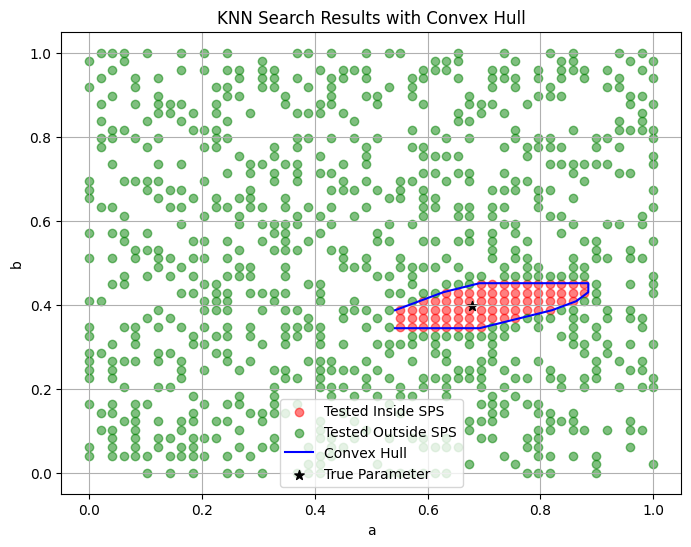

In [8]:
knn_output = np.array(search.get_mapped_output())
knn_in = knn_output[knn_output[:,2] == True]
knn_in = knn_in[:,0:2]
knn_out = knn_output[knn_output[:,2] == False]

knn_hull = ConvexHull(knn_in)
knn_expanded = expand_convex_hull(knn_in[knn_hull.vertices])

knn_intersection = compare_hulls(baseline_expanded[::-1], knn_expanded[::-1])

union_list = np.concatenate([baseline_in, knn_in])
knn_union = ConvexHull(union_list)
union_points = union_list[knn_union.vertices]

# Plot the knn hull
plt.figure(figsize=(8, 6))
if len(knn_in):
    plt.scatter(knn_in[:, 0], knn_in[:, 1], color='red', label='Tested Inside SPS', alpha=0.5)
if len(knn_out):
    plt.scatter(knn_out[:, 0], knn_out[:, 1], color='green', label='Tested Outside SPS', alpha=0.5)
plt.plot(knn_expanded[:,0], knn_expanded[:,1], color='blue', label="Convex Hull")
plt.scatter(center[0], center[1], color='black', marker='*', label='True Parameter', s=50)
plt.xlabel("a")
plt.ylabel("b")
plt.title("KNN Search Results with Convex Hull")
plt.legend()
plt.grid(True)
plt.savefig("figures/knn_search_hull.png")
plt.show()




IoU = 0.788


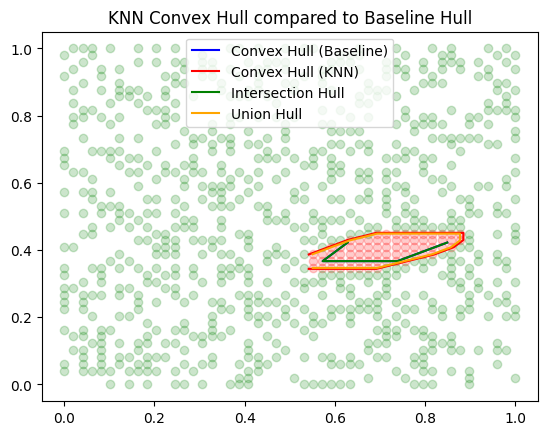

In [9]:
# Hull Comparison
plt.figure()
if len(knn_in):
    plt.scatter(knn_in[:, 0], knn_in[:, 1], color='red', alpha=0.2)
if len(knn_out):
    plt.scatter(knn_out[:, 0], knn_out[:, 1], color='green', alpha=0.2)
plt.plot(baseline_expanded[:,0], baseline_expanded[:,1], color='blue', label="Convex Hull (Baseline)")
plt.plot(knn_expanded[:,0], knn_expanded[:,1], color='red', label="Convex Hull (KNN)")
plt.plot(knn_intersection[:,0], knn_intersection[:,1], color='green', label="Intersection Hull")
plt.plot(union_points[:,0], union_points[:,1], color='orange', label="Union Hull")
plt.title("KNN Convex Hull compared to Baseline Hull")
plt.savefig("figures/knn_search_hull_comparison.png")
plt.legend()

knn_union_area = knn_union.area
knn_intersection_area = ConvexHull(knn_intersection).area

print("IoU = %.3f" % (knn_intersection_area / knn_union_area))


Average SPS calls per angle: 5.18
Total SPS calls: 518
IoU: 0.761
Average SPS calls per angle: 4.24
Total SPS calls: 424
IoU: 0.758
Average SPS calls per angle: 4.33
Total SPS calls: 433
IoU: 0.755
Average SPS calls per angle: 4.32
Total SPS calls: 432
IoU: 0.752
Average SPS calls per angle: 4.09
Total SPS calls: 409
IoU: 0.765


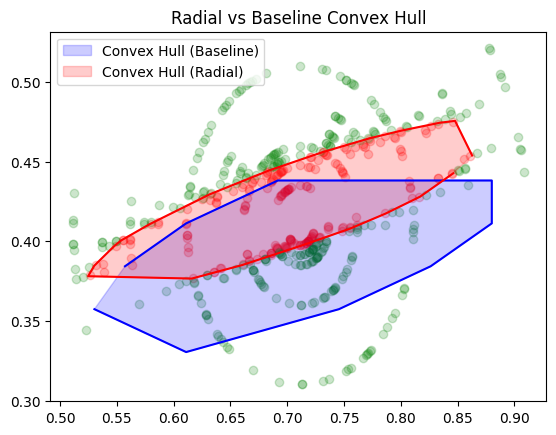

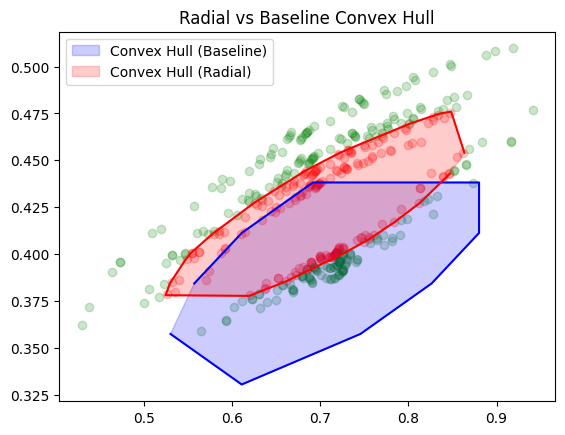

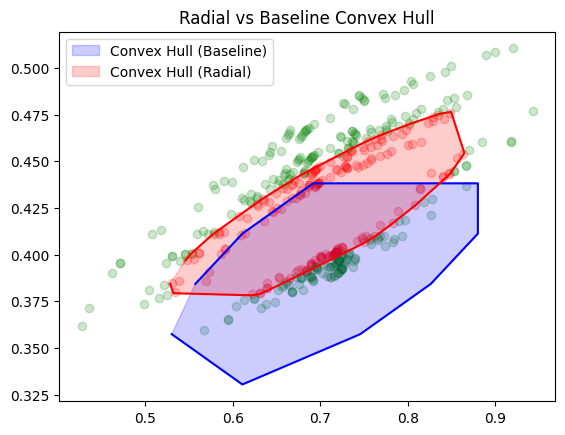

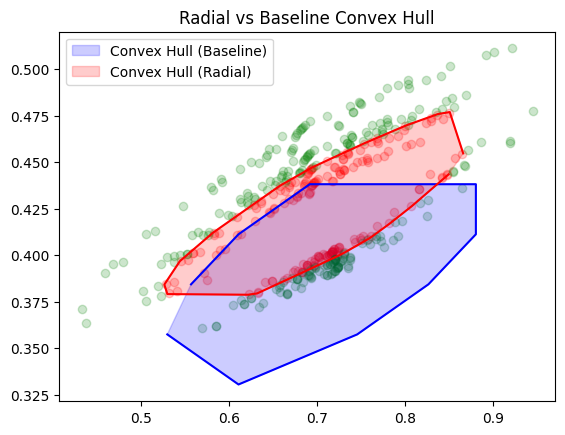

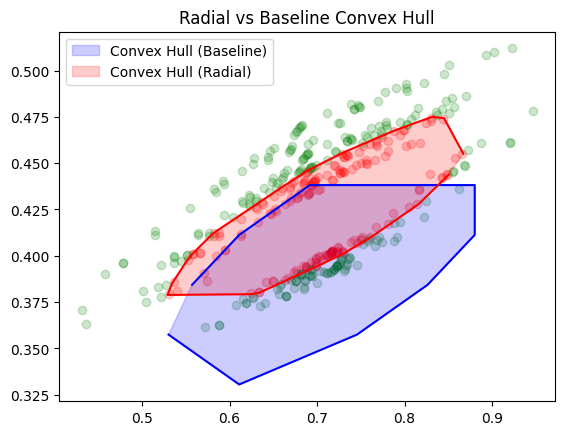

In [32]:
# Radial Search
from search.search_radial import RadialSearch

def create_radial_model(armax_model: ARMAX, n_vectors):
    n_a = len(armax_model.A) - 1
    n_b = len(armax_model.B)
    n_dim = n_a + n_b

    # SISO System
    n_outputs = 1
    n_inputs = 1
    n_noise = -1
    n_states=max(n_a, n_b)

    C_obs = np.array([[0, 1.0]])

    if n_states == 1:
        C_obs = np.array([[1.0]])

    # Initialise the system
    R = signal.square(np.linspace(0, 10*np.pi, n_samples))
    Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.1)

    # Wraper function for calling SPS algorithm with model parameters
    def test_wrapper ( coord):
        global n_sps_calls
        n_sps_calls += 1    # Increment the call count

        return is_inside_region( coord )

    # Calculate the LSE
    lse = get_lse(Y, U)
    
    search = RadialSearch(n_dim=n_dim,
                            n_vectors=n_vectors,
                            center_options=[lse],
                            sps_test_function=test_wrapper)

    return search


def plot_radial_results(radial_ins, radial_outs, radial_expanded_hull):
    print("Average SPS calls per angle: %.2f" % ((len(radial_ins) + len(radial_outs)) / n_random_vectors))
    print("Total SPS calls: %d" % (len(radial_ins) + len(radial_outs)))


    radial_intersection = compare_hulls(baseline_expanded[::-1], radial_expanded_hull[::-1])
    radial_intersection_hull = ConvexHull(radial_intersection)

    union_list = np.concatenate([baseline_in, radial_ins])
    radial_union = ConvexHull(union_list)
    union_points = union_list[radial_union.vertices]

    radial_area_u = radial_union.area
    radial_area_i = radial_intersection_hull.area
    radial_score = radial_area_i / radial_area_u
    print("IoU: %.3f" % radial_score)
    # Hull Comparison
    plt.figure()
    if len(radial_ins):
        plt.scatter(radial_ins[:, 0], radial_ins[:, 1], color='red', alpha=0.2)
    if len(radial_outs):
        plt.scatter(radial_outs[:, 0], radial_outs[:, 1], color='green', alpha=0.2)
    plt.fill(baseline_expanded[:,0], baseline_expanded[:,1], color='blue', label="Convex Hull (Baseline)", alpha=0.2)
    plt.plot(baseline_expanded[:,0], baseline_expanded[:,1], color='blue')
    plt.fill(radial_expanded_hull[:,0], radial_expanded_hull[:,1], color='red', label="Convex Hull (Radial)", alpha=0.2)
    plt.plot(radial_expanded_hull[:,0], radial_expanded_hull[:,1], color='red')
    plt.title("Radial vs Baseline Convex Hull")
    plt.savefig("figures/radial_baseline_hull.png")
    plt.legend()



    # plt.figure()
    # if len(radial_ins):
    #     plt.scatter(radial_ins[:, 0], radial_ins[:, 1], color='red', alpha=0.2)
    # if len(radial_outs):
    #     plt.scatter(radial_outs[:, 0], radial_outs[:, 1], color='green', alpha=0.2)
    # plt.fill(radial_intersection[:,0], radial_intersection[:,1], color='blue', label="Intersection", alpha=0.2)
    # plt.plot(radial_intersection[:,0], radial_intersection[:,1], color='blue')
    # plt.fill(union_points[:,0], union_points[:,1], color='red', label="Union", alpha=0.2)
    # plt.plot(union_points[:,0], union_points[:,1], color='red')


    # plt.title("IoU Score = %.3f" % radial_score, fontsize=10)
    # plt.suptitle("Baseline & Radial Search - Intersection & Union Hulls")
    # plt.savefig("figures/radial_baseline_iou.png")
    # plt.legend()


n_random_vectors = 100

search = create_radial_model(armax_model, n_random_vectors)

for i in range(5):
    radial_ins, radial_outs, boundaries, hull, radial_expanded_hull = search.search()
    plot_radial_results(radial_ins, radial_outs, radial_expanded_hull)


In [12]:

from itertools import combinations

def compare_hulls_n_dim(in_points_1, in_points_2) -> float:
    """Returns the average of IoU measurements for each 2-dimensional permutation of the data"""
    ious = []

    n_dims = in_points_1.shape[1]
    indices = np.arange(n_dims)

    options = list(combinations(indices, 2))

    for i in range(len(options)):
        ins_1 = in_points_1[:, options[i]]
        ins_2 = in_points_2[:, options[i]]

        # plt.figure()
        # plt.plot(ins_1[:,0], ins_1[:,1])
        # plt.plot(ins_2[:,0], ins_2[:,1])
        # plt.show()

        ins_concat = np.vstack([ins_1, ins_2])
        union_hull = ConvexHull(ins_concat)
        union_points = ins_concat[union_hull.vertices]

        hull_union = ConvexHull(union_points)
        hull_intersect = compare_hulls(ins_1[::-1], ins_2[::-1])
        if len(hull_intersect) == 0:
            ious.append(0)
            continue
        knn_intersection_area = ConvexHull(hull_intersect).area

        ious.append(float(knn_intersection_area / knn_union_area))
    return np.mean(ious)


In [13]:
# Simple Benchmark for Radial
import time

import pandas as pd

# Initialize an empty DataFrame with the required columns
benchmark_results = pd.DataFrame(columns=["Model Name", "Number of Vectors", "Number of Calls", "Time Elapsed", "IoU"])

# Function to add a new benchmark result
def add_benchmark_result(model_name, number_of_vectors, number_of_calls, time_elapsed, iou):
    global benchmark_results
    new_result = {
        "Model Name": model_name,
        "Number of Vectors": number_of_vectors,
        "Number of Calls": number_of_calls,
        "Time Elapsed": time_elapsed,
        "IoU": iou
    }

    benchmark_results = pd.concat([benchmark_results, pd.DataFrame([new_result])], ignore_index=True)


# Define test parameters
test_models = [OpenLoop1, OpenLoop2, ClosedLoop1, ClosedLoop2]
# test_models = [OpenLoop1, ClosedLoop1]
test_model_names = ["Open Loop First Order", "Open Loop Second Order", "Closed Loop First Order", "Closed Loop Second Order"]
test_n_vectors = [10, 25, 50, 100, 250, 500]
num_iters = 50

curr_results = []
models_dict = {}

n_sps_calls = 0


# Test each model
for idx, model_under_test in enumerate(test_models):
    print("Testing model", test_model_names[idx])
    n_a = len(model_under_test.A) - 1
    n_b = len(model_under_test.B)
    n_dim = n_a + n_b

    # SISO System
    n_outputs = 1
    n_inputs = 1
    n_noise = -1
    n_states=max(n_a, n_b)
    n_params = len(model_under_test.A) - 1 + len(model_under_test.B)

    is_closed_loop = model_under_test in [ClosedLoop1, ClosedLoop2]
    sps_type = SPSType.CLOSED_LOOP if is_closed_loop else SPSType.OPEN_LOOP

    C_obs = np.array([[0, 1.0]])

    if n_states == 1:
        C_obs = np.array([[1.0]])


    # Initialise SPS Model and helper functions
    model = SPS_indirect_model(m, q, N=n,
                            n_states=n_states, n_inputs=n_inputs, n_outputs=n_outputs,
                            n_noise=n_noise)

    _construct_ss_from_params = get_construct_ss_from_params_method(n_states=n_states, n_inputs=n_inputs, n_outputs=n_outputs, C=C_obs)

    # SPS Test function
    def is_inside_region(point):
        try:
            A_obs, B_obs, C_obs, D_obs, A,B = _construct_ss_from_params(np.ascontiguousarray(point))
            G = d_tfs.ss_to_tf(A_obs, B_obs, C_obs, D_obs, check_assumption=False, epsilon=epsilon)
            if not _is_stable(A, epsilon=epsilon):
                return False
            C = np.array([1.0])

            H = d_tfs((C,A))
            F = d_tfs((np.array(model_under_test.F), [1.0])) if is_closed_loop else None
            L = d_tfs((np.array(model_under_test.L), [1.0])) if is_closed_loop else None
            Lambda = np.array([[1.0, 0],[0, 1.0]]) # shape n_output x n_output
            in_sps = model.sps_indicator(G=G, H=H, A=A, B=B, C=C,
                                Y_t = np.array([Y]), U_t=np.array([U]), sps_type=sps_type, Lambda=None, R_t=np.array([R]), L=L, F=F)
        except Exception as e:
            print(f"Error in SPS check: {e}")
            in_sps = False
        return in_sps


    # Using the true parameters for the center
    center = np.concatenate([model_under_test.A[1:], model_under_test.B])

    # Create the baseline model (Grid Search)
    search_space = []
    n_points = 40
    for _ in range(n_params):
        search_space.append(np.linspace(mins[0], maxes[0], n_points))

    axes = [np.linspace(0, 1, n_points) for _ in range(n_params)]
    mesh = np.meshgrid(*axes, indexing='ij')

    # Stack and reshape to get a list of all coordinate points
    points = np.stack(mesh, axis=-1).reshape(-1, n_params)
    baseline_in = []
    baseline_out = []

    for point in points:
        # point = np.array([a, b])
        in_sps = is_inside_region(point)
        if in_sps:
            baseline_in.append(point)
        else:
            baseline_out.append(point)

    baseline_in = np.array(baseline_in)
    baseline_out = np.array(baseline_out)

    # Hull code
    baseline_hull = ConvexHull(baseline_in)
    baseline_expanded = expand_convex_hull(baseline_in[baseline_hull.vertices])

    # Wrapper function for calling SPS algorithm with model parameters
    def test_wrapper ( coord):
        global n_sps_calls
        n_sps_calls += 1    # Increment the call count

        return is_inside_region( coord )


    # Initialise the system
    R = signal.square(np.linspace(0, 10*np.pi, n_samples))
    Y, U, N, R = model_under_test.simulate(n_samples, R, noise_std=0.1)
    # lse = get_lse(U, Y, model_under_test, n_a, n_b )

    # Test hyperparameter
    for n_vectors in test_n_vectors:
        print("N Vectors: ", n_vectors)

        search = RadialSearch(n_dim=n_dim,
                              n_vectors=n_vectors,
                              center_options=center,
                              sps_test_function=test_wrapper)

        for _ in range(num_iters):
            n_sps_calls = 0
            if IS_VERBOSE:
                print(test_model_names[idx], ":", n_vectors, "-", _)

            start_time = time.time()
            ins, outs, boundaries, hull, expanded_hull = search.search()
            end_time = time.time()
            delta_time = end_time - start_time

            radial_hull = ConvexHull(ins)
            iou_avg = compare_hulls_n_dim(ins[radial_hull.vertices], baseline_in[baseline_hull.vertices])

            add_benchmark_result(model_name=test_model_names[idx], number_of_vectors=n_vectors, number_of_calls=n_sps_calls, time_elapsed=delta_time, iou=iou_avg)

    # Save the benchmark results to a CSV file
benchmark_results.to_csv("radial_search_benchmark_results.csv", index=False)

Testing model Open Loop First Order
N Vectors:  10


C:\Users\Jake\AppData\Local\Temp\ipykernel_28980\2611902556.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  benchmark_results = pd.concat([benchmark_results, pd.DataFrame([new_result])], ignore_index=True)


N Vectors:  25
N Vectors:  50
N Vectors:  100


KeyboardInterrupt: 

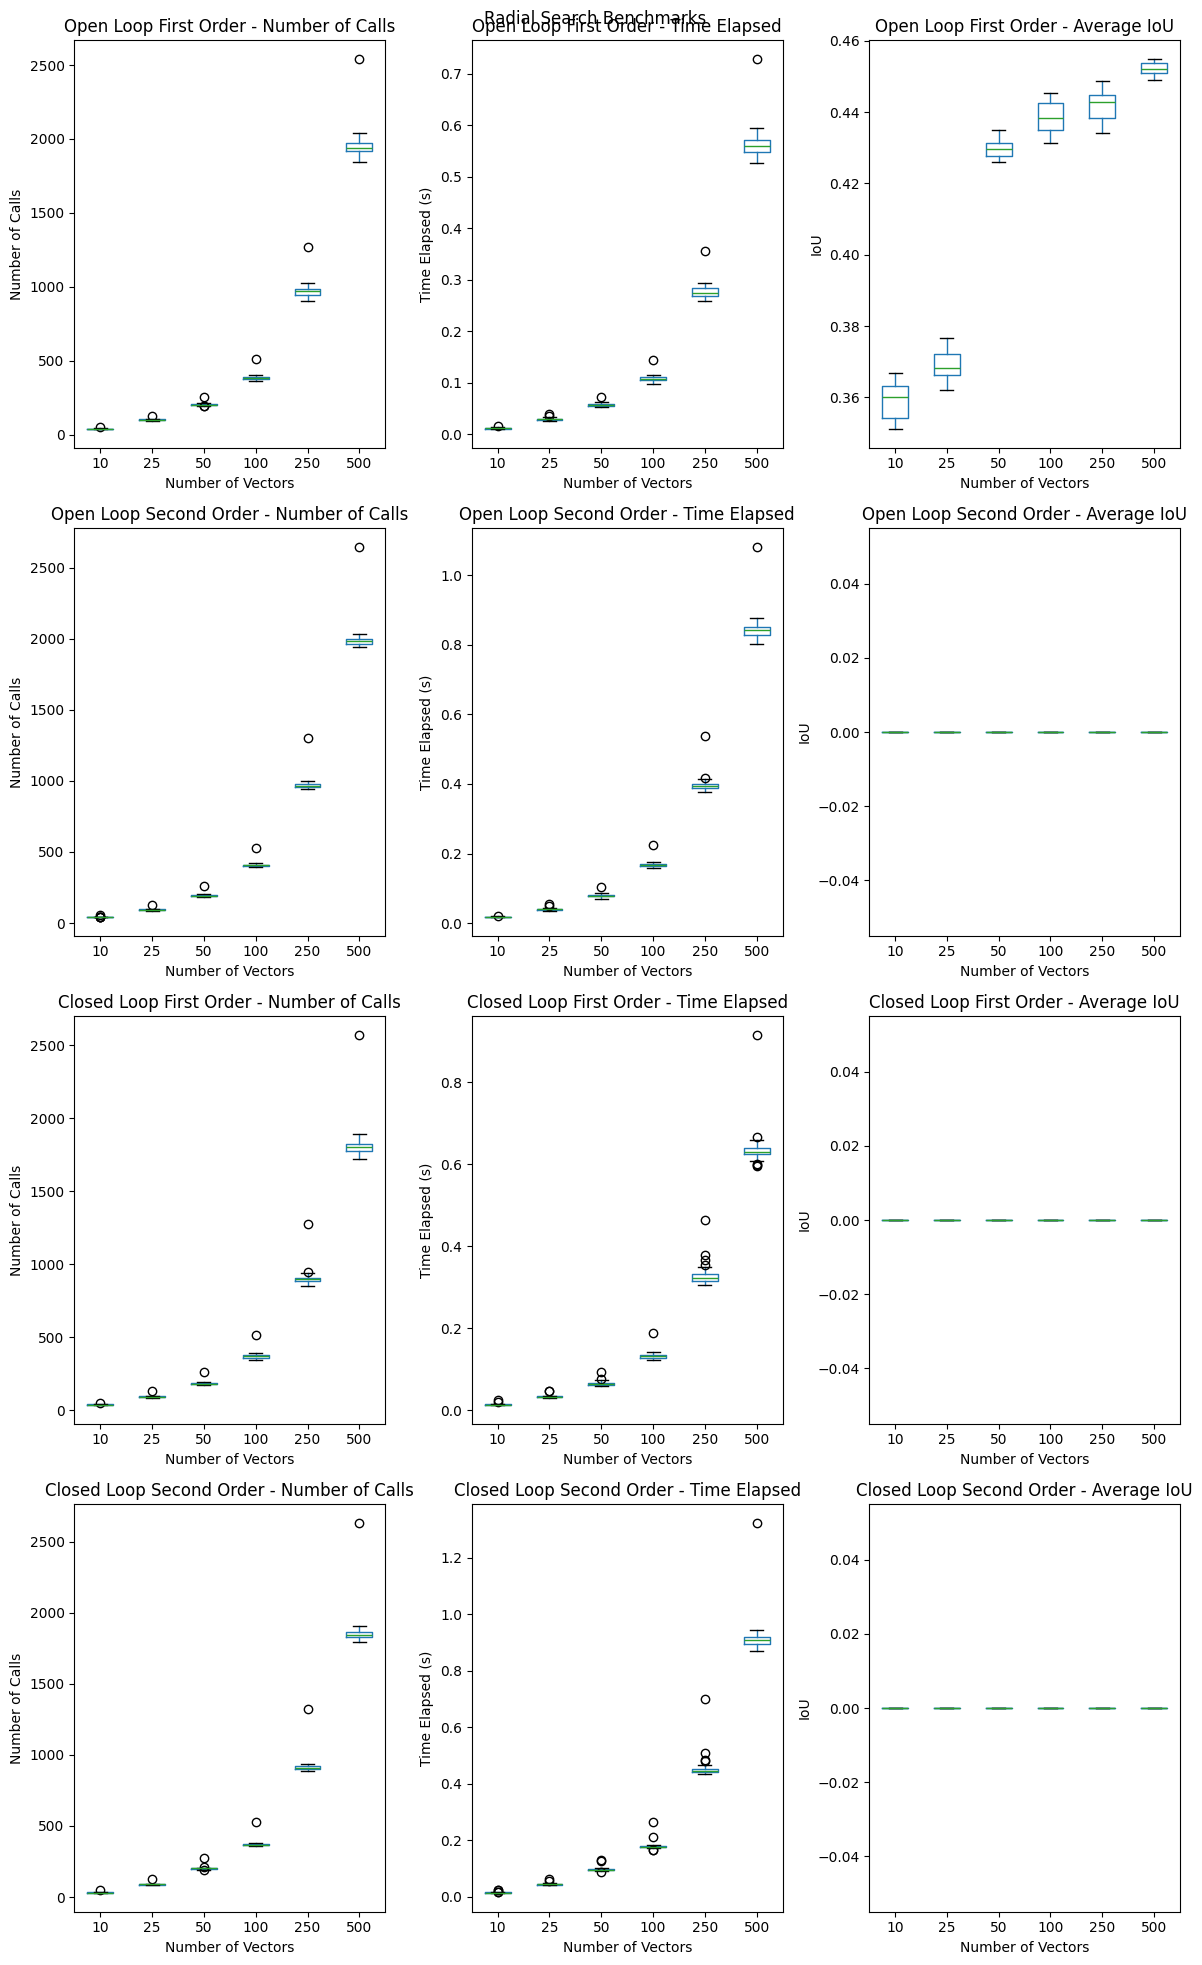

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load benchmark results from CSV
benchmark_results = pd.read_csv("radial_search_benchmark_results.csv")

# Get the unique model names
model_names = benchmark_results["Model Name"].unique()

# Set up subplots: one row per model, two columns (Number of Calls, Time Elapsed)
fig, axes = plt.subplots(nrows=len(model_names), ncols=3, figsize=(12, 5 * len(model_names)))

# If there's only one model, axes might not be a 2D array
if len(model_names) == 1:

    axes = [axes]

# Plot for each model
for i, model in enumerate(model_names):
    model_data = benchmark_results[benchmark_results["Model Name"] == model]

    # Boxplot for Number of Calls
    model_data.boxplot(column="Number of Calls", by="Number of Vectors", ax=axes[i][0], grid=False)
    axes[i][0].set_title(f"{model} - Number of Calls")
    axes[i][0].set_xlabel("Number of Vectors")
    axes[i][0].set_ylabel("Number of Calls")

    # Boxplot for Time Elapsed
    model_data.boxplot(column="Time Elapsed", by="Number of Vectors", ax=axes[i][1], grid=False)
    axes[i][1].set_title(f"{model} - Time Elapsed")
    axes[i][1].set_xlabel("Number of Vectors")
    axes[i][1].set_ylabel("Time Elapsed (s)")

    # Boxplot for Time Elapsed
    model_data.boxplot(column="IoU", by="Number of Vectors", ax=axes[i][2], grid=False)
    axes[i][2].set_title(f"{model} - Average IoU")
    axes[i][2].set_xlabel("Number of Vectors")
    axes[i][2].set_ylabel("IoU")

# Clean up the layout and remove the default suptitle
plt.suptitle("Radial Search Benchmarks")
plt.tight_layout()
plt.show()